# Floodmap Generation

## Overview
In this notebook we will:
- Query and retrieve pertinent shapefiles within a directory structure for a given EMSR emergency event.
- Process and store file names and data quantities associated with an EMSR into a Copernicus metadata dictionary.
- Construct a floodmap from flood events, area of interest, and hydrography.

## Copernicus EMS Rapid Mapping Products

Following the scraping and downloading of Copernicus EMS Rapid Mapping Products in `1_scrape_emsr_copernicus.ipynb`, we unzipped the files in our local file directory. 

Once unzipped, multiple `.shp` files may be associated with a single EMSR Flood Activation Code. These files represent different activation layer data available as Copernicus EMS rapid mapping products. For more details with respect to each of the layers see below.

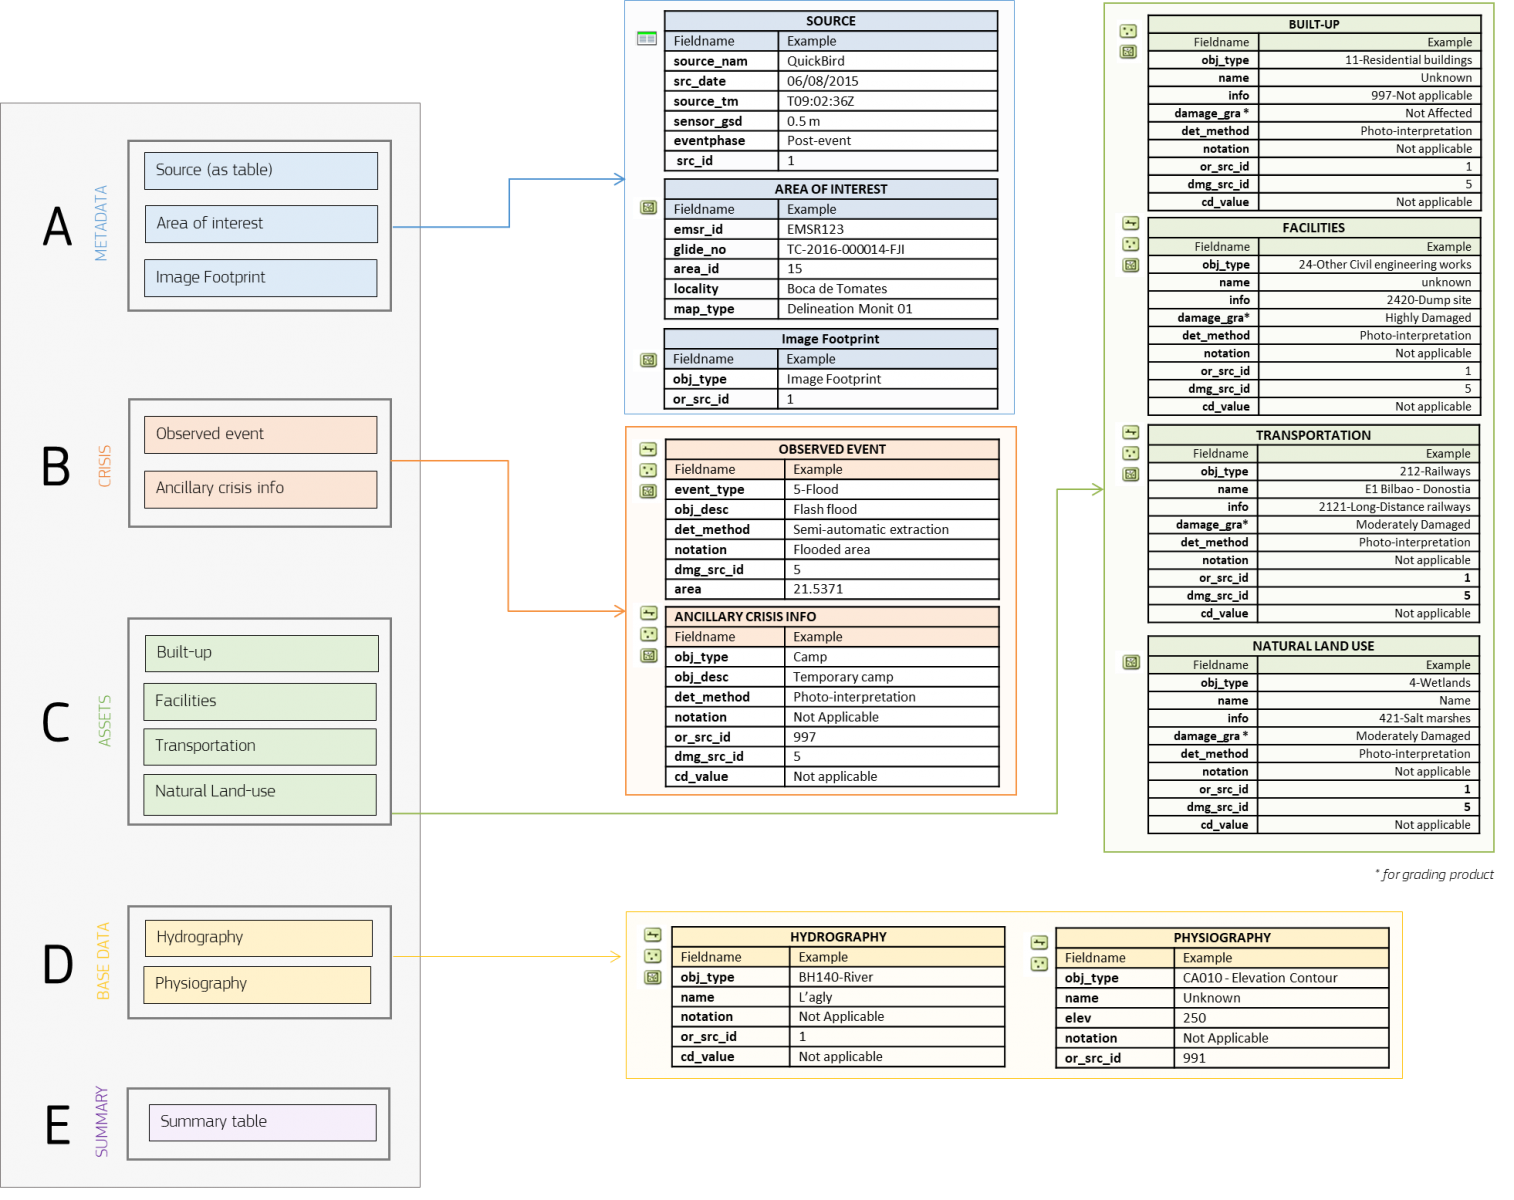

## 1 - Shapefile Retrieval Based on EMSR

The layers of particular value to WorldFloods are the Metadata (A), Crisis (B), and Base Data (D) layers. More specifically, we are interested retrieving:

- A: Source and The Area of Interest (AOI)
- B: Observed Event data for Floods
- D: Hydrography areas and lines indicative of lakes and rivers 

With these data we can create a composite floodmask over an AOI. We will later obtain Sentinel-2 images associated with an AOI which we will overlay with a floodmap layer derived from A, B, and D Copernicus EMS products.

These shapefiles will be used to compose a floodmap for use in the generation of ground truth labels to be used in a supervised learning model pipeline.

Carrying over the previous data from the flood in East Sardinia from notebook 1...

In [1]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Geospatial modules and WorldFloods activations mapping module
import geopandas as gpd
import pickle
import pandas as pd
from src.data.copernicusEMS import activations
from src.data import utils

from pprint import pprint
from google.cloud import storage
from io import BytesIO

In [2]:
activation = "EMSR495"

# csv_file = "gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_codes/ems_activations_20170101_20210301.csv"
csv_file = "gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_codes/ems_activations_20150701_20210304.csv"
table_activations_ems = pd.read_csv(csv_file, encoding="latin1")
table_activations_ems = table_activations_ems.set_index("Code")
table_activations_ems.head()

,Title,CodeDate,Type,Country
Code,,,,
EMSR502,Flood in Southern Ireland,2021-02-23,Flood,Ireland
EMSR501,Flood in Albania,2021-01-06,Flood,Albania
EMSR498,"Flood in Corrèze department, France",2021-02-02,Flood,France
EMSR497,Flood in Germany,2021-02-01,Flood,Germany
EMSR496,"Flood in Lazio Region, Italy",2021-01-26,Flood,Italy


-------

In [3]:
unzipped_activations_parent_dir = "gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip"
# unzipped_activations_parent_dir = "0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip"
unzipped_activations_aoi_dirs = utils.get_files_in_bucket_directory_gs(gs_path=unzipped_activations_parent_dir, suffix=None)
unzipped_activations_aoi_dirs = sorted(list(set([os.path.dirname(f) for f in unzipped_activations_aoi_dirs])))
unzipped_activations_aoi_dirs[:5]

['gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip/EMSR280/01MALUNG',
 'gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip/EMSR280/01MALUNG/VECTOR',
 'gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip/EMSR280/02VANSBRO',
 'gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip/EMSR280/02VANSBRO/VECTOR',
 'gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip/EMSR280/03FALUN']

### 1a - Process Shapefiles 

In function `filter_register_copernicusems` we check that all the `.shp` follow the expected conventions with respect to timestamp and data availability.

### 1b - Populate Copernicus EMSR Metadata Dictionary
`filter_register_copernicusems` upon extracting the source, AOI, observed event, and hydrography information, will populate a dictionary with keys associated with the source data and hold the filenames and paths of specific `.shp` files as values. 

## 2 - Generate Floodmap

We then process the `.shp` files area of interest, observed event, and the hydrography into a single `geopandas.GeoDataFrame` object using `generate_floodmap`. This information will be eventually saved in the WorldFloods database.


Note that steps 1a, 1b, and 2 occur in the cell block below.

- `filter_register_copernicusems` is called to retrieve shape files and populate a Copernicus metadata dictionary.
- `generate_floodmap` retrieves the polygons associated with individual shapefiles and constructs a geopandas DataFrame consolidated the polygons over a particular AOI for an EMSR alert.

In [4]:
code_date = table_activations_ems.loc[activation]["CodeDate"]
print("code_date:", code_date)

sample_activation_dir = os.path.join(unzipped_activations_parent_dir, activation)
pprint(sample_activation_dir)

code_date: 2021-01-22
'gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip/EMSR495'


In [5]:
# filter_register_copernicusems_gcp() function processes every aoi within this activation code
register_list = activations.filter_register_copernicusems_gcp(sample_activation_dir, code_date)
print(len(register_list))
pprint(register_list[0])

# for k in register_list[0]: 
#     print(type(register_list[0][k]))

Multiple event types within shapefile ['Coastal flood' 'Riverine flood']
6
{'abstract': 'NaN',
 'aoi_code': 'AOI01',
 'area_of_interest_file': 'EMSR495_AOI01_DEL_MONIT01_areaOfInterestA_r1_v1.shp',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon object at 0x7fb3ac044820>,
 'bounding_box': {'east': 33.705909407000036,
                  'north': -24.712656954999943,
                  'south': -25.18645625499994,
                  'west': 33.454061058000036},
 'country': 'NaN',
 'ems_code': 'EMSR495',
 'event_id': 'EMSR495_AOI01_DEL_MONIT01_r1_v1',
 'event_type': 'Coastal flood',
 'hydrology_file_a': 'EMSR495_AOI01_DEL_MONIT01_hydrographyA_r1_v1.shp',
 'hydrology_file_l': 'EMSR495_AOI01_DEL_MONIT01_hydrographyL_r1_v1.shp',
 'layer_name': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1',
 'observed_event_file': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1.shp',
 'purpose': 'NaN',
 'reference_system': {'code': '4326', 'code_space': 'epsg'},
 'satellite': 'Sentinel-1',
 'sa

In [6]:
import datetime
import json
import os
import shutil
import zipfile
from glob import glob
from typing import Dict, List, Optional

import geopandas as gpd
import numpy as np
import pandas as pd
import requests
from requests_html import HTMLSession
from shapely.ops import cascaded_union

from src.data import utils
from src.data.config import ACCEPTED_FIELDS, RENAME_SATELLITE
COLUMN_W_CLASS_OBSERVED_EVENT = "notation"
COLUMN_W_CLASS_HYDRO = "obj_type"

In [7]:
# FOR SCRIPT TO RUN ON THE WHOLE DATASET -Saves data locally and then moves it to the cloud.
import json
import geopandas as gpd
import subprocess
from tqdm import tqdm
from src.data import utils


data_store = "1_Staging"
gcp_output_parent_dir = f"gs://ml4cc_data_lake/0_DEV/{data_store}/WorldFloods/"

register_list = activations.filter_register_copernicusems_gcp(sample_activation_dir, code_date)

with tqdm(register_list) as pbar:
    for metadata_floodmap in pbar:
        # unzipped_activations_parent_dir contains all the extracted files.
        floodmap = activations.generate_floodmap_gcp(metadata_floodmap, folder_files=unzipped_activations_parent_dir)
        
        # push metadata to bucket
        gcp_metadata_floodmap_path = os.path.join(gcp_output_parent_dir,
                                                  "flood_meta",
                                                  metadata_floodmap['ems_code'], 
                                                  metadata_floodmap['aoi_code'],
                                                  f"{metadata_floodmap['event_id']}_metadata_floodmap.pickle")
        utils.write_pickle_to_gcp(gs_path=gcp_metadata_floodmap_path, dict_val=metadata_floodmap)
        
        # push floodmap to bucket
        gcp_floodmap_path = os.path.join(gcp_output_parent_dir,
                                         "floodmap",
                                         metadata_floodmap['ems_code'], 
                                         metadata_floodmap['aoi_code'],
                                         f"{metadata_floodmap['event_id']}_floodmap.geojson")
        utils.write_geojson_to_gcp(gs_path=gcp_floodmap_path, geojson_val=floodmap)
        


Multiple event types within shapefile ['Coastal flood' 'Riverine flood']


  0%|          | 0/6 [00:00<?, ?it/s]/home/ahmedn/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
 17%|█▋        | 1/6 [00:01<00:09,  1.87s/it]/home/ahmedn/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
 33%|███▎      | 2/6 [00:03<00:06,  1.53

In [8]:
#def generate_floodmap_gcp(metadata_floodmap: Dict, folder_files:str, filterland:bool=True) -> gpd.GeoDataFrame:
""" Generates a floodmap with the joined info of the hydro and flood. 
Works the same way as the generate_floodmap() function but reads files from the bucket."""

folder_files = unzipped_activations_parent_dir
filterland = True

area_of_interest_file = os.path.join(folder_files, 
                                     metadata_floodmap["ems_code"], 
                                     metadata_floodmap["aoi_code"], 
                                     metadata_floodmap["area_of_interest_file"])
area_of_interest = gpd.read_file(area_of_interest_file)

area_of_interest_pol = cascaded_union(area_of_interest["geometry"])

observed_event_file = os.path.join(folder_files, 
                                   metadata_floodmap["ems_code"], 
                                   metadata_floodmap["aoi_code"], 
                                   metadata_floodmap["observed_event_file"])
mapdf = utils.filter_pols(gpd.read_file(observed_event_file), area_of_interest_pol)
assert mapdf.shape[0] > 0, f"No polygons within bounds for {metadata_floodmap}"

floodmap = gpd.GeoDataFrame({"geometry": mapdf.geometry},
                            crs=mapdf.crs)
floodmap["w_class"] = mapdf[COLUMN_W_CLASS_OBSERVED_EVENT]
floodmap["source"] = "flood"

if "hydrology_file_a" in metadata_floodmap:
    hydrology_file_a = os.path.join(folder_files, 
                                    metadata_floodmap["ems_code"], 
                                    metadata_floodmap["aoi_code"],  
                                    metadata_floodmap["hydrology_file_a"])

    mapdf_hydro = utils.filter_pols(gpd.read_file(hydrology_file_a), area_of_interest_pol)

#     ######################DEEEELLLETE
#     print(hydrology_file_a)
#     mapdf_hydro = utils.filter_land(mapdf_hydro) if filterland and (mapdf_hydro.shape[0] > 0) else mapdf_hydro

#     if mapdf_hydro.shape[0] > 0:
#         mapdf_hydro["source"] = "hydro"
#         mapdf_hydro = mapdf_hydro.rename({COLUMN_W_CLASS_HYDRO: "w_class"}, axis=1)
#         mapdf_hydro = mapdf_hydro[["geometry", "w_class", "source"]].copy()
#         floodmap = pd.concat([floodmap, mapdf_hydro], axis=0, ignore_index=True)

# # Add "hydrology_file_l"?? must be handled in later in create_gt.compute_water function
# if "hydrology_file_l" in metadata_floodmap:
#     hydrology_file_l = os.path.join(folder_files, 
#                                     metadata_floodmap["ems_code"], 
#                                     metadata_floodmap["aoi_code"],  
#                                     metadata_floodmap["hydrology_file_l"])

#     mapdf_hydro = utils.filter_pols(gpd.read_file(hydrology_file_l), area_of_interest_pol)
#     if mapdf_hydro.shape[0] > 0:
#         mapdf_hydro["source"] = "hydro_l"
#         mapdf_hydro = mapdf_hydro.rename({COLUMN_W_CLASS_HYDRO: "w_class"}, axis=1)
#         mapdf_hydro = mapdf_hydro[["geometry", "w_class", "source"]].copy()
#         floodmap = pd.concat([floodmap, mapdf_hydro], axis=0, ignore_index=True)

# # Concat area of interest
# area_of_interest["source"] = "area_of_interest"
# area_of_interest["w_class"] = "area_of_interest"
# area_of_interest = area_of_interest[["geometry", "w_class", "source"]].copy()
# floodmap = pd.concat([floodmap, area_of_interest], axis=0, ignore_index=True)

# assert floodmap.crs is not None, "Unexpected error. floodmap is not georreferenced!"

# floodmap.loc[floodmap.w_class.isna(), 'w_class'] = "Not Applicable"

#    return floodmap

In [9]:
#mapdf_hydro['geometry'][46]

# for i, poly in enumerate(mapdf_hydro['geometry']):
#     if not poly.is_valid:
#         print(i)
        

# mapdf_hydro = utils.filter_land(mapdf_hydro) if filterland and (mapdf_hydro.shape[0] > 0) else mapdf_hydro
# mapdf_hydro